# **STAT-201 Project Report**
## Do data analysts and data scientists differ in salaries and work flexibility? 

Prabh Sehgal, Rainie Fu, Rishabh Mathur, Dennis Truong

## Introduction

A key factor in employee happiness is financial compensation, and past work during the COVID-19 pandemic have shown that working remotely can also have a positive impact on happiness thanks to increased employee autonomy (Card et al., 2012; Galanti et al., 2021). Our of data science salaries analysis aims to explore the relationships between different data science jobs, their salaries, and their proportions doing remote work. Our analyses can inform prospective emplyees about each position's remote work flexibility and typical salary. Employees may use these inferences to discover new data science occupations that better align with their work-life goals.

### Research Question
Which profession pays more, data scientists or analysts, and who works more remotely?

### Dataset


Our research utilizes the dataset "Data Science Job Salaries" by Ruchi Bhatia (2022) from [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries). Observations include the year the salary was paid, experience level, work kind, title, salary, remote ratio, firm size, and company location. The main observations we aim to use are the ```job_title``` to tell us the job type, the ```salary_in_USD``` to inform us about each role's salary, and the ```remote_ratio``` to give us the proportion of poeple working remotely in that respective role.

## Preliminary Results

### Reading the Data

We downloaded the data to our repository and read it from there since Kaggle does not let datasets to be read straight from the website.

In [3]:
# Load libraries
install.packages("infer")
library(tidyverse)
library(infer)
library(repr)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)
library(GGally)
library(scales)
library(broom)
library(digest)

# Set seed
set.seed(4204)

# Get url of dataset from the web|
url <- "https://raw.githubusercontent.com/vindennt/stat-201-project-group-10/main/ds_salaries.csv"

# Use suppressMessages() to avoid the warning message when it automatically gives a
# name to the first column, which are just indecies
salaries <- suppressMessages(
read_delim(url, delim = ",") %>%
select(!...1))

# Preview data
head(salaries)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


**Table 1:** Preview of the data science salary dataset to be analyzed.

### Cleaning and Wrangling Data

Let's look at which of the many ```job_title``` categories in this dataset we can use.

In [4]:
# Filter for sample size > 30 and full time workers
salaries <- salaries %>%
    filter(employment_type == "FT") %>%
    group_by(job_title) %>%
    mutate(n = n()) %>%
    filter(n > 30)

# Preview the remaining job titles
large_job_groups <- as.list(unique(salaries$job_title))
large_job_groups

[[1]]
[1] "Data Scientist"

[[2]]
[1] "Machine Learning Engineer"

[[3]]
[1] "Data Analyst"

[[4]]
[1] "Data Engineer"

Here we can see that the first three categories each have more than 30 observations, meaning they are large enough, and are similar in size. Of those three, Data Scientist is a very broad job definition, so we will compare Data Scientists and Data Analysts.
Let's grab only those categories and store them in a dataframe named ```top_jobs```.

In [5]:
inperson <- salaries %>% # Classify no remote work as being in person work
    filter(remote_ratio == 0) %>%
    mutate(remote_ratio = "in person")
hybrid <- salaries %>%
    filter(remote_ratio == 50) %>% # Classify partial remote work as a hybrid format
    mutate(remote_ratio = "hybrid")
remote <- salaries %>%
    filter(remote_ratio == 100) %>%
    mutate(remote_ratio = "remote") # Classify 100% remote work as full remote work
# Remove unecessary columns
salaries_new <- rbind(inperson, hybrid, remote) %>%
    select(-salary_currency, -salary, -employee_residence, -company_location, -employment_type) 

# Preview resulting data
head(salaries_new)

work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size,n
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>
2020,MI,Data Scientist,79833,in person,L,140
2020,EN,Data Scientist,51321,in person,S,140
2020,MI,Data Scientist,40481,in person,L,140
2020,EN,Data Scientist,39916,in person,M,140
2020,MI,Machine Learning Engineer,43331,in person,M,41
2020,SE,Data Engineer,33511,in person,S,129


**Table 2:** Preview of the cleaned and filtered data science salary dataset to be analyzed.

### Plots

#### Salary distributions

Let's start by plotting the salary distributions for each of the categories side by side.
Also, we'll include red vertical lines to display their mean incomes.

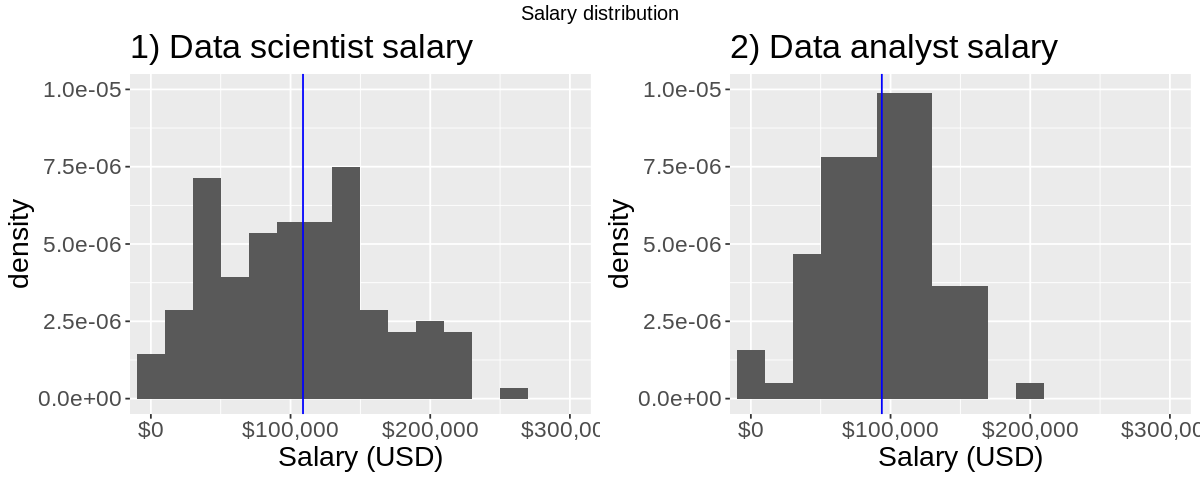

In [20]:
options(repr.plot.width = 10, repr.plot.height = 4)

# visualize distribution of data scientist salaries
ds_salary_dist <- salaries_new %>%
    filter(job_title == "Data Scientist") %>%
    ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
    geom_histogram(binwidth = 20000) +
    labs(x = "Salary (USD)", title = "1) Data scientist salary") +
    geom_vline(xintercept = mean(filter(salaries_new, job_title == "Data Scientist")$salary_in_usd), color = "blue") + # mark mean to make easier to see
    scale_x_continuous(labels = scales::dollar_format()) + # put money in the human-readable unit of USD
    coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) + # set x axis to readable scale
    theme(text = element_text(size = 17)) # Set text size to easily readable size

    

# visualize distribution of data analyst salaries
pda_salary_dist <- salaries_new %>% 
    filter(job_title == "Data Analyst") %>%
    ggplot(aes(x = salary_in_usd, y = after_stat(density))) +
    geom_histogram(binwidth = 20000) +
    labs(x = "Salary (USD)", title = "2) Data analyst salary") +
    geom_vline(xintercept = mean(filter(salaries_new, job_title == "Data Analyst")$salary_in_usd), color = "blue") +
    scale_x_continuous(labels = scales::dollar_format()) +
    coord_cartesian(xlim = c(0, 300000), ylim = c(0, 1e-05)) +
    theme(text = element_text(size = 17))

grid.arrange(ds_salary_dist, pda_salary_dist, ncol = 2, top = "Salary distribution")

**Figure 1 & 2:** Salary distributions for data scientists and data analysts in USD from companies of all sizes.

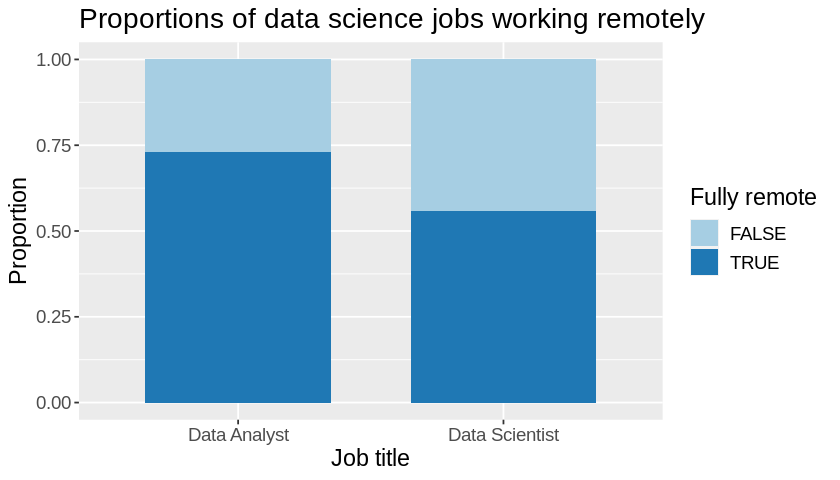

In [10]:
options(repr.plot.width = 7, repr.plot.height = 4)

# Create a bar graph with proportions represented by proprtions of the bar occupied by correspdoning coloer
remote_prop_visual <- salaries_new %>%
    filter(job_title == "Data Analyst" | job_title == "Data Scientist") %>%
    ggplot(aes(x = job_title, fill = remote_ratio == "remote")) +
    geom_bar(position = "fill", width = 0.7) +
    xlab("Job title") +
    ylab("Proportion") +
    ggtitle("Proportions of data science jobs working remotely") +
    labs(fill = "Fully remote") +
    scale_fill_brewer(palette = "Paired") +
    theme(text = element_text(size = 14))

remote_prop_visual

**Figure 3:** Proportion of data science jobs working remotely.

### Estimates

We require the right point estimates prior to testing our hypotheses.

In [22]:
# We are only interested in data analyst and data scientist, so we filter these to job_titles out
salaries_new <- salaries_new %>%
        filter(job_title == "Data Analyst" | job_title == "Data Scientist")

# Here, we will calculate basic point estimate statistics for future inferences.
data_estimates <- salaries_new %>%
    group_by(job_title) %>%
    summarize(n = n(),
              salary_mean = mean(salary_in_usd), 
              salary_sd = sd(salary_in_usd), 
              remote_prop = mean(remote_ratio == "remote"), 
              remote_sd = sqrt(remote_prop * (1 - remote_prop)))
    

# Preview point estimates
head(data_estimates)

job_title,n,salary_mean,salary_sd,remote_prop,remote_sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Data Analyst,96,93752.84,39258.60,0.7291667,0.4443902
Data Scientist,140,108922.79,64372.43,0.5571429,0.4967240


**Table 3:** Point estimates of salary and remote ratio statistics

## Methods

### Plan

Up till now, the report has demonstrated differences in mean salaries and proportions of remote work among Data Scientists and Data Analysts. To ensure randomness, representative samples of full-time employees with sample sizes greater than 30 were used.
However, relying on point estimates and plots alone is not enough to establish these differences. Therefore, to address this issue, the report proposes using the Central Limit Theorem, as the samples are roughly normally distributed and less computationally intensive than resampling methods.
By letting Data Scientists be population 1, and Data Analysts as population 2, we aim to test the following hypothesis for the mean salary:
$$H_0 : \mu_2 - \mu_1 = 0$$
$$H_1 : \mu_2 - \mu_1 \neq 0$$

for the proportion of remote work:
$$H_0 : p_2 - p_1 = 0$$
$$H_1 : p_2 - p_1 \neq 0$$

where $\mu$ is the population's mean salary and $p$ is its proportion of employees working remotely. 

We expect to reject both null hypotheses, and will include a 90% confidence interval in our final report.

### Impact

The outcomes of these findings could affect the decisions of newly graduated data scientists in terms of which job positions to seek and which career paths to focus on during their undergraduate studies.

### Future

This prompts further questions about how differences in experience, company location, and company size may affect the comparison of job titles in the field of Data Science. Additionally, with more data, these issues can be explored for the other professions that were not thoroughly examined due to limitations in sample size and distribution.

## Results

In [26]:
# Seed set at initiation

# Get 1000 bootstrap samples
bootstrapped_samples <- salaries_new %>%
        ungroup() %>%
        rep_sample_n(size = nrow(salaries_new), reps = 1000, replace = TRUE) %>%
        group_by(replicate, job_title) %>% 
        summarise(salary_sd = sd(salary_in_usd),
        ratio_sd = sqrt((mean(remote_ratio == "remote") * (1-mean(remote_ratio == "remote")))/n())) # standard deviation of sample proportion                                                       
head(bootstrapped_samples)
       

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,job_title,salary_sd,ratio_sd
<int>,<chr>,<dbl>,<dbl>
1,Data Analyst,43450.08,0.04756760
1,Data Scientist,55777.35,0.04176198
2,Data Analyst,37702.03,0.04543840
2,Data Scientist,60226.76,0.04064313
3,Data Analyst,36292.35,0.04960999
3,Data Scientist,63284.83,0.03987789


**Table 3:** Snippet of bootstrapped data based on 1000 replicates

In [27]:
# Use quantiles method to get 90% confidence intervals
salary_sd_ci <- bootstrapped_samples %>%
        group_by(job_title) %>%
        summarise(lower_ci = quantile(salary_sd, 0.05),
                  upper_ci = quantile(salary_sd, 0.95))
salary_sd_ci

ratio_sd_ci <- bootstrapped_samples %>%
        group_by(job_title) %>%
        summarise(lower_ci = quantile(ratio_sd, 0.05),
                  upper_ci = quantile(ratio_sd, 0.95))
ratio_sd_ci

job_title,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Data Analyst,34607.09,43275.18
Data Scientist,55945.96,72540.01


job_title,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Data Analyst,0.04003386,0.04997987
Data Scientist,0.03994991,0.04384844


**Table 4.** Confidence intervals of salary distributions (top) and remote ratios (bottom).

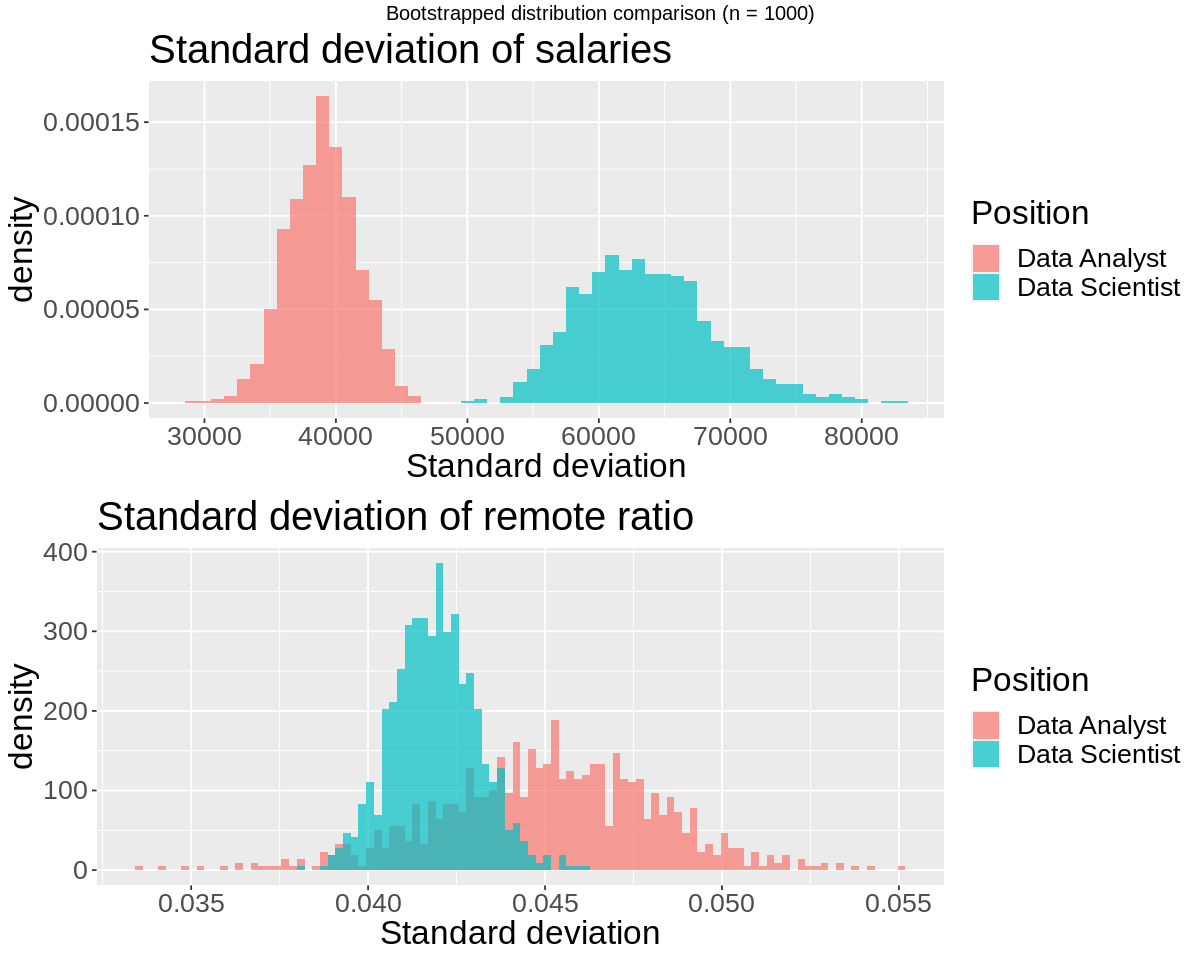

In [28]:
options(repr.plot.width = 10, repr.plot.height = 8) # setting dimensions

# visualize distributions of standard deviation of salaries
bootstrap_dist_salary_sd <- bootstrapped_samples %>%
    ggplot(aes(x = salary_sd, y = ..density.., fill = job_title)) +
    geom_histogram(binwidth = 1000, position = "identity", alpha = 0.7) +
    xlab("Standard deviation") +
    ggtitle("Standard deviation of salaries") +
    labs(fill = "Position") +
    theme(text = element_text(size = 20))

# visualize distributions of standard deviation of remote ratios
bootstrap_dist_ratio_sd <- bootstrapped_samples %>%
    ggplot(aes(x = ratio_sd, y = ..density.., fill = job_title)) +
    geom_histogram(bins = 100, position = "identity", alpha = 0.7) +
    xlab("Standard deviation") +
    ggtitle("Standard deviation of remote ratio") +
    labs(fill = "Position") +
    theme(text = element_text(size = 20))

grid.arrange(bootstrap_dist_salary_sd, bootstrap_dist_ratio_sd, top = "Bootstrapped distribution comparison (n = 1000)")

**Figure 4.** Bootstrap distributions of standard deviation of salaries and remote work ratios for Data Analysts and Data Scientists.

## Hypothesis Testing

In [16]:
# for difference in salary means
analyst <- salaries_new %>%
        filter(job_title == "Data Analyst") %>%
        select(salary_in_usd)
scientist <- salaries_new %>%
        filter(job_title == "Data Scientist") %>%
        select(salary_in_usd)
t_test_diff_mean <- 
    tidy(
        t.test(x = scientist$salary_in_usd,
               y = analyst$salary_in_usd,
               alternative = "two.sided"))
t_test_diff_mean

Adding missing grouping variables: `job_title`
Adding missing grouping variables: `job_title`


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
15169.95,108922.8,93752.84,2.245166,0.02570363,231.1716,1857.336,28482.56,Welch Two Sample t-test,two.sided


**Table 5.** Two sided t-test statistics for difference in salary means between data scientists and data analysts

In [17]:
# for difference in proportions of remote ratio
analyst_prop <- salaries_new %>%
        filter(job_title == "Data Analyst") 
scientist_prop <- salaries_new %>%
        filter(job_title == "Data Scientist") 
prop_test <- tidy(
    prop.test(x = c(sum(analyst_prop$remote_ratio == "remote"), sum(scientist_prop$remote_ratio == "remote")),
              n = c(nrow(analyst_prop), nrow(scientist_prop)),
              correct = FALSE))
prop_test

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.7291667,0.5571429,7.206825,0.007262684,1,0.05089389,0.2931537,2-sample test for equality of proportions without continuity correction,two.sided


**Table 6.** Two sided t-test statistics for difference in remote ratio between data scientists and data analysts

# Discussion

# References

Bhatia, R. (2022). *Data science job salaries*. https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

Card, D., Mas, A., Moretti, E., & Saez, E. (2012). Inequality at work: The effect of peer salaries on job satisfaction. *American Economic Review*, 102(6), 2981–3003. https://doi.org/10.1257/aer.102.6.2981

Galanti, T., Guidetti, G., Mazzei, E., Zappalà, S., & Toscano, F. (2021). Work from home during the COVID-19 outbreak: the impact on employees' remote work productivity, engagement, and stress. *Journal of Occupational and Environmental Medicine*, 63(7), e426–e432. https://doi.org/10.1097/JOM.0000000000002236